In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import polygon as sk_polygon

from skimage import img_as_ubyte

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Target image size (you can easily step this up later)
TARGET_IMAGE_SIZE = 4096

# Smallest feature size target (in pixels)
PIXEL_RESOLUTION_TARGET = 1

# Scaling parameters
BASE_SCALE = 0.7  # Fraction of image size that the base triangle will occupy
MAX_ITERATIONS = 20  # Safety cap on number of Koch iterations

# Plotting parameters
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120


In [3]:
def initialize_triangle_segments(scale=1.0):
    """
    Initialize a mathematically correct equilateral triangle.
    
    Returns:
        segments: list of 2x2 numpy arrays, each representing a line segment.
    """

    # Define equilateral triangle vertices
    A = np.array([0.0, 0.0])
    B = np.array([1.0, 0.0])
    C = np.array([0.5, np.sqrt(3)/2])

    # Stack into array
    points = np.array([A, B, C])

    # Scale triangle around center (0.5, 0.5)
    centroid = np.mean(points, axis=0)
    points = (points - centroid) * scale + [0.5, 0.5]

    # Create segments
    segments = [
        np.array([points[0], points[1]]),
        np.array([points[1], points[2]]),
        np.array([points[2], points[0]])
    ]

    return segments

def koch_iteration_step(segments):
    """
    Perform one full Koch refinement step on a list of segments.
    
    Inputs:
        segments: list of 2x2 numpy arrays (start point, end point)
        
    Outputs:
        new_segments: updated list of refined segments
    """

    new_segments = []

    for seg in segments:
        A, B = seg  # Start and end points

        d = B - A

        # Subdivision points
        P1 = A + (1/3) * d
        P2 = A + (2/3) * d

        # Midpoint of middle third
        mid = (P1 + P2) / 2

        # Outward bump (ROTATE -90° to fix bump direction)
        d_norm = d / np.linalg.norm(d)
        bump_direction = np.array([d_norm[1], -d_norm[0]])  # Rotate -90°
        bump_height = (np.linalg.norm(d) / 3) * np.sqrt(3) / 2
        bump = mid + bump_direction * bump_height

        # Create 4 new segments
        new_segments.append(np.array([A, P1]))
        new_segments.append(np.array([P1, bump]))
        new_segments.append(np.array([bump, P2]))
        new_segments.append(np.array([P2, B]))

    return new_segments

def rasterize_segments(segments, image_size):
    """
    Rasterize segments into a binary mask for visualization or measurement.
    
    Inputs:
        segments: list of 2x2 numpy arrays
        image_size: size of output binary array
        
    Outputs:
        mask: (image_size, image_size) binary numpy array
    """

    mask = np.zeros((image_size, image_size), dtype=bool)

    for seg in segments:
        A, B = seg

        # Scale coordinates to image pixel coordinates
        A_px = (A * (image_size - 1)).astype(int)
        B_px = (B * (image_size - 1)).astype(int)

        # Simple linear interpolation between A and B
        num_points = max(abs(B_px - A_px)) + 1  # Ensure pixel connectivity
        x_vals = np.linspace(A_px[0], B_px[0], num_points).astype(int)
        y_vals = np.linspace(A_px[1], B_px[1], num_points).astype(int)

        # Clip in case of boundary overshoots
        x_vals = np.clip(x_vals, 0, image_size - 1)
        y_vals = np.clip(y_vals, 0, image_size - 1)

        mask[y_vals, x_vals] = True

    return mask

Iteration 0: 3 segments, Avg Segment ~ 2866.50 pixels


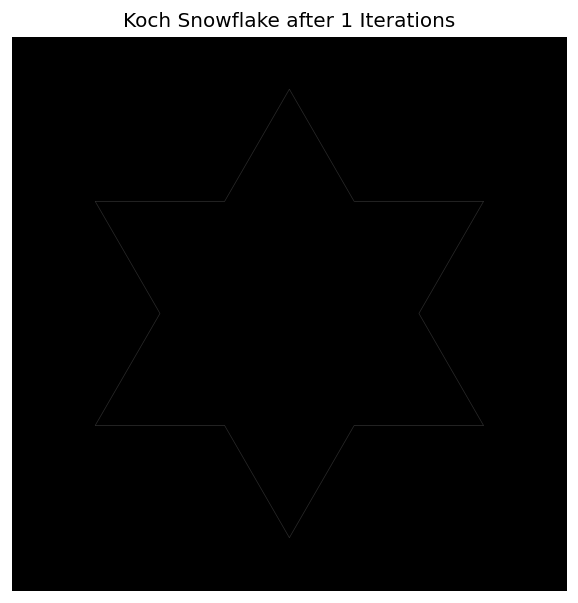

Iteration 1: 12 segments, Avg Segment ~ 955.50 pixels


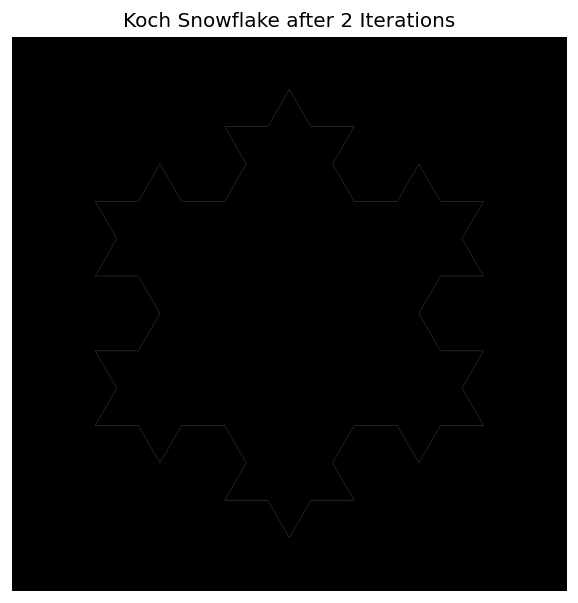

Iteration 2: 48 segments, Avg Segment ~ 318.50 pixels


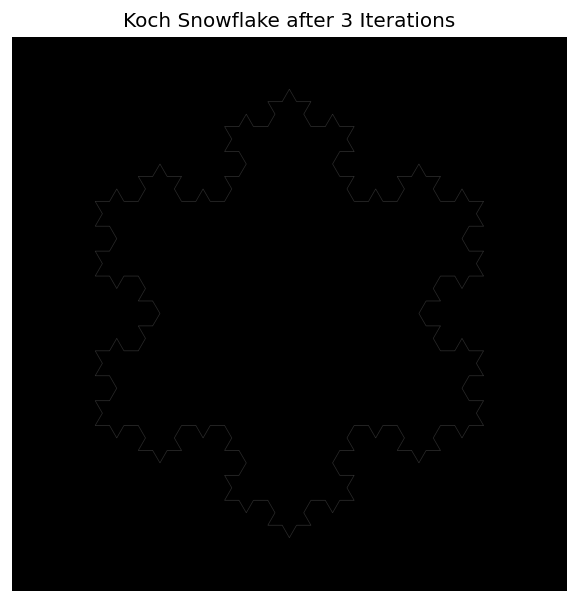

Iteration 3: 192 segments, Avg Segment ~ 106.17 pixels


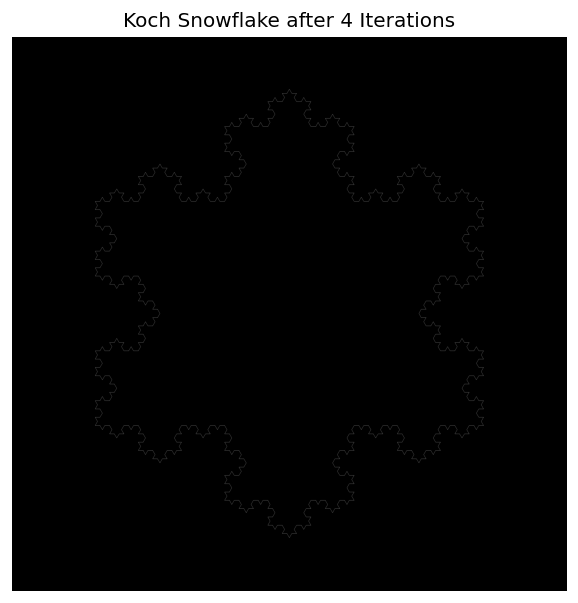

Iteration 4: 768 segments, Avg Segment ~ 35.39 pixels


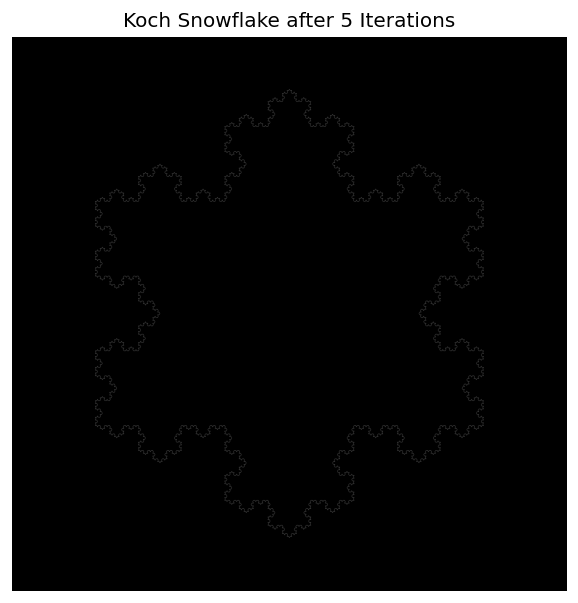

Iteration 5: 3072 segments, Avg Segment ~ 11.80 pixels


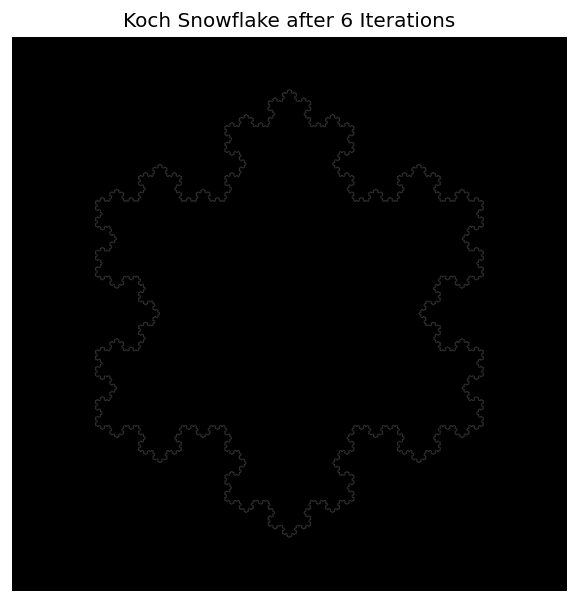

Iteration 6: 12288 segments, Avg Segment ~ 3.93 pixels


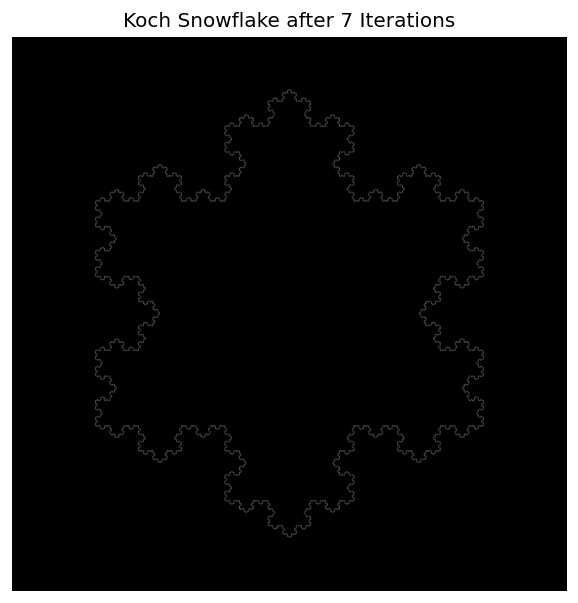

Iteration 7: 49152 segments, Avg Segment ~ 1.31 pixels


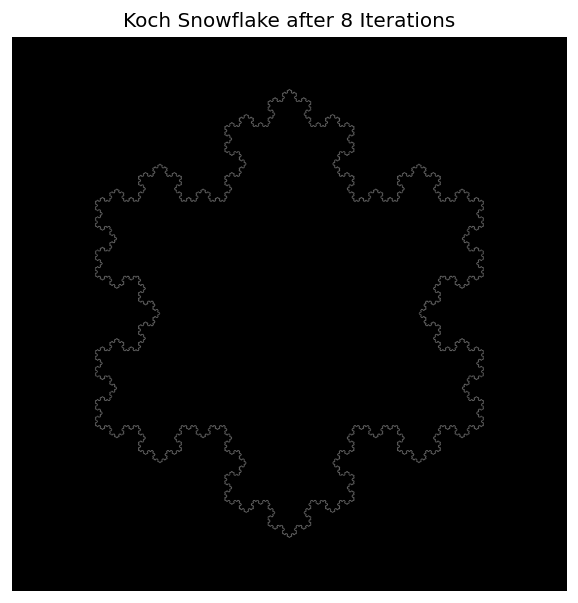

Iteration 8: 196608 segments, Avg Segment ~ 0.44 pixels
Reached pixel resolution limit. Stopping refinement.


In [4]:
# Step 1: Initialize base triangle
segments = initialize_triangle_segments(scale=BASE_SCALE)

# Step 2: Set up iteration counter
iteration = 0

# Step 3: Main iteration loop
while iteration < MAX_ITERATIONS:
    # Estimate the average segment length
    total_length = np.sum([np.linalg.norm(seg[1] - seg[0]) for seg in segments])
    avg_segment_length = total_length / len(segments)

    # Convert length to approximate pixel size
    approx_pixel_size = avg_segment_length * (TARGET_IMAGE_SIZE - 1)

    print(f"Iteration {iteration}: {len(segments)} segments, Avg Segment ~ {approx_pixel_size:.2f} pixels")

    # Stop if segment length hits pixel resolution target
    if approx_pixel_size < PIXEL_RESOLUTION_TARGET:
        print("Reached pixel resolution limit. Stopping refinement.")
        break

    # Otherwise, refine further
    segments = koch_iteration_step(segments)
    iteration += 1

    # Optional: Rasterize and visualize every few iterations
    if iteration % 1 == 0:  # Change to %5, %10, etc. if you want fewer plots
        mask = rasterize_segments(segments, image_size=TARGET_IMAGE_SIZE)
        plt.figure(figsize=(6,6))
        plt.imshow(mask, cmap='gray')
        plt.title(f"Koch Snowflake after {iteration} Iterations")
        plt.axis('off')
        plt.show()

In [76]:
from skimage.transform import resize
from skimage.measure import perimeter

from scipy.ndimage import binary_fill_holes

from scipy.ndimage import convolve

def compute_perimeter_4_connected(mask):
    """
    Compute perimeter of a binary mask using 4-connected convolution method.
    """
    # Define 4-connectivity kernel (cross pattern)
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    # Convolve
    neighbor_count = convolve(mask.astype(int), kernel, mode='constant', cval=0)

    # A pixel is a perimeter pixel if it has a neighbor count < 4 and is part of the mask
    perimeter_pixels = (mask) & (neighbor_count < 4)

    return np.sum(perimeter_pixels)

def rasterize_segments_to_size(segments, image_size):
    """
    Rasterize segments onto a binary mask of specified image size and fill enclosed areas.
    
    Inputs:
        segments: list of 2x2 numpy arrays
        image_size: int (output image size, assumed square)
        
    Outputs:
        mask: (image_size, image_size) binary numpy array (filled)
    """
    mask = np.zeros((image_size, image_size), dtype=bool)

    for seg in segments:
        A, B = seg

        # Scale logical coordinates [0,1] -> pixel space
        A_px = (A * (image_size - 1)).astype(int)
        B_px = (B * (image_size - 1)).astype(int)

        # Draw line
        num_points = max(abs(B_px - A_px)) + 1
        x_vals = np.linspace(A_px[0], B_px[0], num_points).astype(int)
        y_vals = np.linspace(A_px[1], B_px[1], num_points).astype(int)

        x_vals = np.clip(x_vals, 0, image_size - 1)
        y_vals = np.clip(y_vals, 0, image_size - 1)

        mask[y_vals, x_vals] = True

    # Fill inside the shape
    filled_mask = binary_fill_holes(mask)

    return filled_mask


def measure_area_perimeter(mask):
    """
    Given a binary mask, compute area and perimeter (4-connected perimeter).
    """
    area = np.sum(mask)
    peri = compute_perimeter_4_connected(mask)
    return area, peri

from tqdm import tqdm

def multi_raster_area_perimeter(segments, min_size=256, max_size=4096, num_sizes=50, plot_some=False):
    """
    Rasterize the same segments at multiple image sizes and measure (Area, Perimeter).
    Optionally plot a few sample images.
    
    Inputs:
        segments: list of 2x2 numpy arrays
        min_size: smallest raster size
        max_size: largest raster size
        num_sizes: number of raster sizes to sample
        plot_some: if True, plot a few sampled rasterized masks
        
    Outputs:
        areas: numpy array of areas
        perimeters: numpy array of perimeters
        sizes: numpy array of raster sizes used
    """
    sizes = np.linspace(min_size, max_size, num_sizes, dtype=int)
    areas = []
    perimeters = []

    # Choose some random indices to plot
    plot_indices = set(np.linspace(0, len(sizes)-1, 5, dtype=int)) if plot_some else set()

    for idx, size in enumerate(tqdm(sizes, desc="Rasterizing and Measuring")):
        mask = rasterize_segments_to_size(segments, size)
        area, peri = measure_area_perimeter(mask)
        areas.append(area)
        perimeters.append(peri)

        if plot_some and idx in plot_indices:
            plt.figure(figsize=(4,4))
            plt.imshow(mask, cmap='gray')
            plt.title(f"Raster Size: {size}")
            plt.axis('off')
            plt.show()

    return np.array(areas), np.array(perimeters), sizes

def plot_loglog_perimeter_vs_area(areas, perimeters):
    """
    Plot log(Perimeter) vs log(Area) and estimate fractal dimension.
    """
    logA = np.log(areas)
    logP = np.log(perimeters)

    valid = np.isfinite(logA) & np.isfinite(logP)
    logA = logA[valid]
    logP = logP[valid]

    if len(logA) < 2:
        raise ValueError("Not enough valid points to fit.")

    slope, intercept = np.polyfit(logA, logP, 1)
    D_estimate = 2 * slope

    plt.figure(figsize=(6,6))
    plt.plot(logA, logP, 'o-', label=f'Slope={slope:.4f}, D~{D_estimate:.4f}')
    plt.xlabel('log(Area)')
    plt.ylabel('log(Perimeter)')
    plt.title('Perimeter vs Area Scaling')
    plt.legend()
    plt.grid(True)
    plt.show()

    return D_estimate







































































































Rasterizing and Measuring: 100%|██████████| 50/50 [11:52<00:00, 14.25s/it]


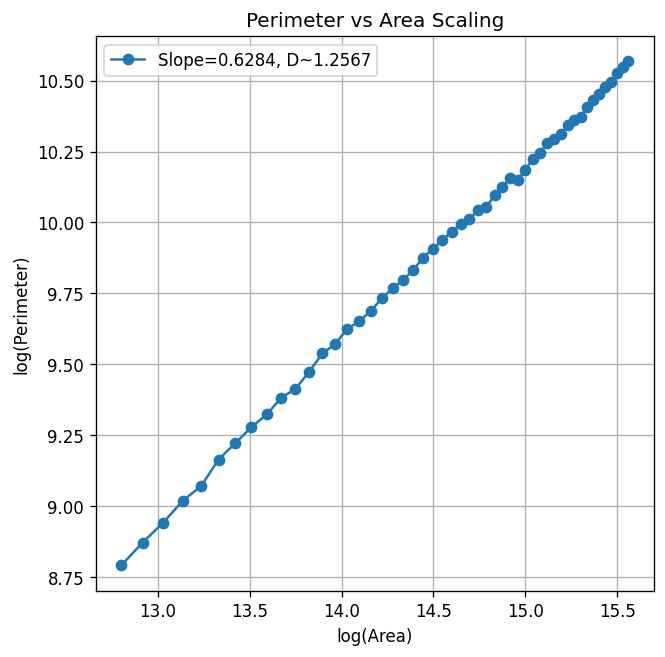

Estimated Fractal Dimension D ≈ 1.25673


In [78]:
areas, perimeters, sizes = multi_raster_area_perimeter(
    segments,
    min_size=1024,
    max_size=4096,
    num_sizes=50, 
    plot_some=False
)

D_estimate = plot_loglog_perimeter_vs_area(areas, perimeters)

print(f"Estimated Fractal Dimension D ≈ {D_estimate:.5f}")